In [50]:
import os, json, sys
from itertools import izip
import numpy as np
import importlib
from spearmint.utils.database.mongodb import MongoDB
from spearmint.main import parse_resources_from_config, load_jobs, \
    remove_broken_jobs, load_task_group, load_hypers
from collections import OrderedDict
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import pymongo
%matplotlib inline

In [51]:
def get_options(dir_path):
    # Read in the config file
    expt_dir  = os.path.realpath(os.path.expanduser(dir_path))
    if not os.path.isdir(expt_dir):
        raise Exception("Cannot find directory %s" % expt_dir)
    expt_file = os.path.join(expt_dir, 'config.json')

    try:
        with open(expt_file, 'r') as f:
            options = json.load(f, object_pairs_hook=OrderedDict)
    except:
        raise Exception("config.json did not load properly. Perhaps a spurious comma?")
    options["config"]  = 'config.json'

    # Set sensible defaults for options
    options['chooser']  = options.get('chooser', 'default_chooser')
    if 'tasks' not in options:
        options['tasks'] = {'main' : {'type' : 'OBJECTIVE', 'likelihood' : options.get('likelihood', 'GAUSSIAN')}}

    if not os.path.exists(expt_dir):
        sys.stderr.write("Cannot find experiment directory '%s'. "
                         "Aborting.\n" % (expt_dir))
        sys.exit(-1)

    return options, expt_dir

In [52]:
def print_dict(d, level=1):
    if isinstance(d, dict):
        if level > 1: print ""
        for k, v in d.iteritems():
            print "  " * level, k,
            print_dict(v, level=level+1)
    else:
        print d 

In [60]:
options, ext_dir = get_options('../spearmint/metric-test/')

In [62]:
dba = options['database']['address']
dbn = options['database']['name']
experiment_name = options.get("experiment-name", 'unnamed-experiment')

In [63]:
print experiment_name

metric-test


In [65]:
db = MongoDB(database_address=dba, database_name=dbn)

In [48]:
jobs = load_jobs(db, experiment_name)
resources = parse_resources_from_config(options)
resource = resources.itervalues().next()

In [69]:
db.db[experiment_name]['jobs'].drop()
db.db[experiment_name]['hypers'].drop()

In [49]:
jobs

[{u'_id': ObjectId('569e0315ba36a6b4286c5ccf'),
  u'end time': None,
  u'expt_dir': u'/home/05/45881/ba-thesis-code/spearmint/slp-2',
  u'id': 1,
  u'language': u'PYTHON',
  u'main-file': u'train.py',
  u'params': {u'border': {u'type': u'int', u'values': array([ 2.])},
   u'eta': {u'type': u'float', u'values': array([ 0.01])},
   u'lmbda': {u'type': u'float', u'values': array([ 0.])},
   u'n_hidden_layer': {u'type': u'int', u'values': array([ 80.])}},
  u'proc_id': 39535,
  u'resource': u'Main',
  u'start time': 1453196047.97512,
  u'status': u'pending',
  u'submit time': 1453196047.828655,
  u'tasks': [u'main']}]

In [16]:
# Load up the chooser.
chooser_module = importlib.import_module('spearmint.choosers.' + options['chooser'])
chooser = chooser_module.init(options)
print "chooser", chooser

Not running from main.
Not running from main.
chooser <spearmint.choosers.default_chooser.DefaultChooser object at 0x7f895d74e950>


In [17]:
task_options = { task: options["tasks"][task] for task in resource.tasks }
print "task_options:"
print_dict(task_options) # {'main': {'likelihood': u'NOISELESS', 'type': 'OBJECTIVE'}}

task_options:
   main 
     likelihood NOISELESS
     type OBJECTIVE


In [18]:
task_group = load_task_group(db, options, resource.tasks)
print "task_group", task_group # TaskGroup
print "tasks:"
print_dict(task_group.tasks)

task_group <spearmint.tasks.task_group.TaskGroup object at 0x7f897c6d4cd0>
tasks:
   main <spearmint.tasks.task.Task object at 0x7f8942a24a50>


In [19]:
hypers = load_hypers(db, experiment_name)
print "loaded hypers", hypers

loaded hypers {u'main': {u'chain length': 640, u'hypers': {u'amp2': 1.2087587889662834, u'beta_alpha': array([ 5.47461632,  5.68689867,  8.74059071,  0.62469197]), u'ls': array([ 0.38124616,  7.16327919,  0.08611816,  0.98754834]), u'beta_beta': array([ 0.37543721,  1.78785332,  4.58498507,  0.25713112]), u'mean': -0.041126920842657566}}, u'_id': ObjectId('569d3b9aba36a6b4286c5c76')}


In [20]:
hypers = chooser.fit(task_group, hypers, task_options)
print "\nfitted hypers:"
print_dict(hypers)


fitted hypers:
   main 
     chain length 650
     hypers 
       amp2 1.39034986796
       beta_alpha [ 4.92586659  5.54658304  9.26404615  0.70346703]
       ls [ 1.13594596  9.93712637  0.06537027  1.12484633]
       beta_beta [ 0.75643388  1.44589611  4.51461746  1.05320495]
       mean 0.997472409131


Fitting GP for main task...


In [21]:
lp, x = chooser.best()
x = x.flatten()
print "best", lp, x
bestp = task_group.paramify(task_group.from_unit(x))
print "expected best position", bestp

best -0.760751701944 [ 0.13989258  0.2722168   0.54223633  0.03930664]
expected best position {u'n_hidden_layer': {'values': array([ 112.]), 'type': u'int'}, u'eta': {'values': array([ 0.05880127]), 'type': u'float'}, u'border': {'values': array([ 2.]), 'type': u'int'}, u'lmbda': {'values': array([ 0.00786133]), 'type': u'float'}}



Minimum expected objective value under model is -0.00272 (+/- 0.00435), at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                n_hidden_lay  int        112         
                eta           float      0.058801    
                border        int        2           
                lmbda         float      0.007861    

Minimum of observed values is 0.000187, at location:
                NAME          TYPE       VALUE
                ----          ----       -----
                n_hidden_lay  int        200         
                eta           float      0.046496    
                border        int        2           
                lmbda         float      0.000000    


In [79]:
# get the grid of points
grid = chooser.grid
#     print "chooser objectives:", 
#     print_dict(chooser.objective)
print "chooser models:", chooser.models
print_dict(chooser.models)
obj_model = chooser.models[chooser.objective['name']]
obj_mean, obj_var = obj_model.function_over_hypers(obj_model.predict, grid)

chooser models: {'main': <spearmint.models.gp.GP object at 0x7fc1a480ee90>}
   main <spearmint.models.gp.GP object at 0x7fc1a480ee90>


In [80]:
grid

array([[ 0.        ,  0.        ],
       [ 0.5       ,  0.5       ],
       [ 0.75      ,  0.25      ],
       ..., 
       [ 0.5430848 ,  0.1512512 ],
       [ 0.54309733,  0.15102969],
       [ 0.54288707,  0.15140965]])

In [62]:
# un-normalize the function values and variances
obj_task = task_group.tasks['main']
obj_mean = [obj_task.unstandardize_mean(obj_task.unstandardize_variance(v)) for v in obj_mean]
obj_std = [obj_task.unstandardize_variance(np.sqrt(v)) for v in obj_var]

In [82]:
grid = map(task_group.from_unit, grid)

In [70]:
xymv = [(xy[0], xy[1], m, v) for xy, m, v in izip(grid, obj_mean, obj_std)]# if .2 < xy[0] < .25] 

In [73]:
x = map(lambda x:x[0], xymv)
y = map(lambda x:x[1], xymv)
m = map(lambda x:x[2], xymv)
sig = map(lambda x:x[3], xymv)

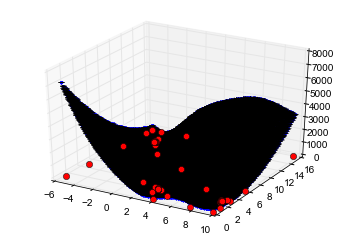

In [76]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, m, marker='.', linestyle="None")

# plot errorbars
for i in np.arange(0, len(x)):
    ax.plot([x[i], x[i]], [y[i], y[i]], [m[i]+sig[i], m[i]-sig[i]], marker="_", color='k')

# get the observed points
task = task_group.tasks['main']
idata = task.valid_normalized_data_dict
xy = idata["inputs"]
xy = map(task_group.from_unit, xy)
xy = np.array(xy)
vals = idata["values"]
vals = [obj_task.unstandardize_mean(obj_task.unstandardize_variance(v)) for v in vals]

ax.plot(xy[:,0], xy[:,1], vals, marker='o', color="r", linestyle="None")
    
plt.show()